### Analisis Grandient Boostin (mejor modelo)

En esta sección, se aplicó el modelo Gradient Boosting Regressor previamente ajustado y optimizado, enfocándose en la evaluación de su desempeño. El objetivo principal fue analizar su capacidad de predicción mediante métricas clave y presentar los resultados de manera visual para facilitar la interpretación.

 Pasos principales:
1. Validación Cruzada:
   - Se implementó una validación cruzada con 10 folds para garantizar que el modelo generalice adecuadamente a nuevos datos.
   - Se calcularon las métricas R², MSE y MAE para cada fold, evaluando así la estabilidad del modelo.

2. Evaluación en el Conjunto de Prueba:
   - El modelo optimizado se probó en un conjunto de datos reservado (test), que no fue utilizado durante el entrenamiento.
   - Se obtuvieron las métricas R², MSE y MAE, las cuales reflejan el desempeño del modelo en escenarios reales.

In [39]:
# Importamos las bibliotecas necesarias
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.ensemble import GradientBoostingRegressor  # Importamos GradientBoostingRegressor
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from scipy.stats import randint, uniform
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import warnings

# Opcional: Suprimir advertencias para una salida más limpia
warnings.filterwarnings('ignore')

# Cargamos el dataset
Graduados_total = pd.read_excel('Graduados_total.xlsx') 

# Función para remover valores atípicos de una columna del DataFrame
def remover_atipicos(df, columna):
    q1, q3 = df[columna].quantile([0.25, 0.75])
    iqr = q3 - q1
    limite_bajo, limite_alto = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return df[(df[columna] >= limite_bajo) & (df[columna] <= limite_alto)]

# Aplicamos la función para remover valores atípicos en la columna 'GRADUADOS'
Graduados_total = remover_atipicos(Graduados_total, 'GRADUADOS')

# Definición de variables objetivo y características
target = 'GRADUADOS'
x = Graduados_total.drop(columns=[target])
y = Graduados_total[target]

# Seleccionamos características numéricas y categóricas
columnas_numericas = [
    'DOCENTES',
    'MATRICULADOS', 'MATRICULADOS_P', 'POBLACION', 'DEFUNCIONES', 'PIB',
    'HOG_CABECERA', 'HOG_CPRD', 'HOG_TOTAL', 'INFLACION ANUAL%',
    'INFLACION TOTAL', 'CASOS_V', 'NACIMIENTOS'
]

columnas_categoricas = ['AREA_CON', 'AÑO']

# División de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

# Escalamos la variable objetivo 'y' usando RobustScaler
scaler_y = RobustScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# Definimos el preprocesador para los datos numéricos y categóricos
preprocesador = make_column_transformer(
    (RobustScaler(), columnas_numericas),
    (OneHotEncoder(sparse_output=False, handle_unknown='ignore'), columnas_categoricas)
)

# Creamos el pipeline de preprocesamiento y regresión de Gradient Boosting
pipeline = make_pipeline(
    preprocesador,
    GradientBoostingRegressor(random_state=42)
)

# Definimos el espacio de hiperparámetros para GradientBoostingRegressor
param_distributions = {
    'gradientboostingregressor__n_estimators': randint(100, 1000),               # Número de árboles
    'gradientboostingregressor__learning_rate': uniform(0.01, 0.3),              # Tasa de aprendizaje
    'gradientboostingregressor__max_depth': randint(1, 30),                     # Profundidad máxima del árbol
    'gradientboostingregressor__min_samples_split': randint(2, 20),             # Mínimo de muestras para dividir un nodo
    'gradientboostingregressor__min_samples_leaf': randint(1, 20),              # Mínimo de muestras en una hoja
    'gradientboostingregressor__max_features': ['sqrt', 'log2', None],          # Número de características a considerar al buscar la mejor división
    'gradientboostingregressor__subsample': uniform(0.5, 0.5),                   # Submuestreo para cada árbol
    'gradientboostingregressor__criterion': ['friedman_mse', 'squared_error', 'absolute_error']  # Criterio de división
}

# Configuramos RandomizedSearchCV para optimizar los hiperparámetros de GradientBoostingRegressor
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=50,            # Número de combinaciones a probar
    cv=5,                 # Validación cruzada con 5 folds
    scoring='r2',         # Métrica de evaluación
    random_state=42,
    n_jobs=-1,            # Utiliza todos los núcleos disponibles
    verbose=1,            # Para ver el progreso de la búsqueda
    error_score=np.nan    # Asigna NaN en caso de error, evitando fallos completos
)

# Entrenamos el modelo con la búsqueda aleatoria usando y_train_scaled
random_search.fit(X_train, y_train_scaled)

# Validación cruzada con 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)
r2_scores, mse_scores, mae_scores = [], [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_train), 1):
    X_fold_train, X_fold_test = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_fold_train, y_fold_test = y_train_scaled[train_idx], y_train_scaled[test_idx]
    
    # Entrenamos el mejor modelo encontrado por RandomizedSearchCV
    best_model = random_search.best_estimator_
    best_model.fit(X_fold_train, y_fold_train)
    
    # Realizamos las predicciones
    y_fold_pred = best_model.predict(X_fold_test)
    
    # Calculamos las métricas sobre los valores escalados
    r2 = best_model.score(X_fold_test, y_fold_test)
    mse = mean_squared_error(y_fold_test, y_fold_pred)
    mae = mean_absolute_error(y_fold_test, y_fold_pred)
    
    r2_scores.append(r2)
    mse_scores.append(mse)
    mae_scores.append(mae)
    
    print(f"  Fold {fold}: R²={r2:.4f}, MSE={mse:.4f}, MAE={mae:.4f}")

# Resultados de la validación cruzada
print("\nResultados de validación cruzada (escala normalizada):")
print("R² scores para cada fold:")
for i, score in enumerate(r2_scores, 1):
    print(f"  Fold {i}: {score:.4f}")
print("\nMSE para cada fold:")
for i, mse in enumerate(mse_scores, 1):
    print(f"  Fold {i}: {mse:.4f}")
print("\nMAE para cada fold:")
for i, mae in enumerate(mae_scores, 1):
    print(f"  Fold {i}: {mae:.4f}")

# Calcular y mostrar los promedios de las métricas
print("\nPromedios de validación cruzada (escala normalizada):")
print(f"  Promedio R²: {np.mean(r2_scores):.4f}")
print(f"  Promedio MSE: {np.mean(mse_scores):.4f}")
print(f"  Promedio MAE: {np.mean(mae_scores):.4f}")

# Evaluación del modelo optimizado en el conjunto de prueba usando y_test_scaled
r2_test = random_search.best_estimator_.score(X_test, y_test_scaled)
y_pred_test_scaled = random_search.best_estimator_.predict(X_test)
mse_test = mean_squared_error(y_test_scaled, y_pred_test_scaled)
mae_test = mean_absolute_error(y_test_scaled, y_pred_test_scaled)

print("\nResultados en el conjunto de prueba (escala normalizada):")
print(f"R² en el conjunto de test: {r2_test:.4f}")
print(f"MSE en el conjunto de test: {mse_test:.4f}")
print(f"MAE en el conjunto de test: {mae_test:.4f}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
  Fold 1: R²=0.8122, MSE=0.2573, MAE=0.2258
  Fold 2: R²=0.8289, MSE=0.1897, MAE=0.2311
  Fold 3: R²=0.9024, MSE=0.1172, MAE=0.1992
  Fold 4: R²=0.9168, MSE=0.0868, MAE=0.1717
  Fold 5: R²=0.8804, MSE=0.1720, MAE=0.2152
  Fold 6: R²=0.8550, MSE=0.1759, MAE=0.2257
  Fold 7: R²=0.9139, MSE=0.1055, MAE=0.1811
  Fold 8: R²=0.8961, MSE=0.1150, MAE=0.2052
  Fold 9: R²=0.8701, MSE=0.1282, MAE=0.2234
  Fold 10: R²=0.8773, MSE=0.1625, MAE=0.1958

Resultados de validación cruzada (escala normalizada):
R² scores para cada fold:
  Fold 1: 0.8122
  Fold 2: 0.8289
  Fold 3: 0.9024
  Fold 4: 0.9168
  Fold 5: 0.8804
  Fold 6: 0.8550
  Fold 7: 0.9139
  Fold 8: 0.8961
  Fold 9: 0.8701
  Fold 10: 0.8773

MSE para cada fold:
  Fold 1: 0.2573
  Fold 2: 0.1897
  Fold 3: 0.1172
  Fold 4: 0.0868
  Fold 5: 0.1720
  Fold 6: 0.1759
  Fold 7: 0.1055
  Fold 8: 0.1150
  Fold 9: 0.1282
  Fold 10: 0.1625

MAE para cada fold:
  Fold 1: 0.2258
  Fold 2: 0.23

Análisis de Resultados: Valores Predichos y Errores

En esta sección, se evalúa visualmente el desempeño del modelo Gradient Boosting Regressor en el conjunto de prueba mediante dos gráficos principales:

1. Gráfica de Valores Predichos vs Valores Reales:
   - Esta gráfica muestra la relación entre los valores reales (normalizados) y los valores predichos por el modelo.
   - Incluye una línea ideal en rojo, que representa una predicción perfecta. Los puntos más cercanos a esta línea indican una mejor precisión del modelo.
   - Permite evaluar la capacidad del modelo para replicar los valores reales y detectar posibles sesgos.

2. Distribución de Errores:
   - Se calculan los errores como la diferencia entre los valores reales y los valores predichos.
   - Se presenta un histograma que muestra la distribución de estos errores, acompañado de una curva de densidad para identificar patrones.
   - Una distribución centrada cerca de cero y con baja dispersión indica que el modelo es preciso y no tiene desviaciones sistemáticas.

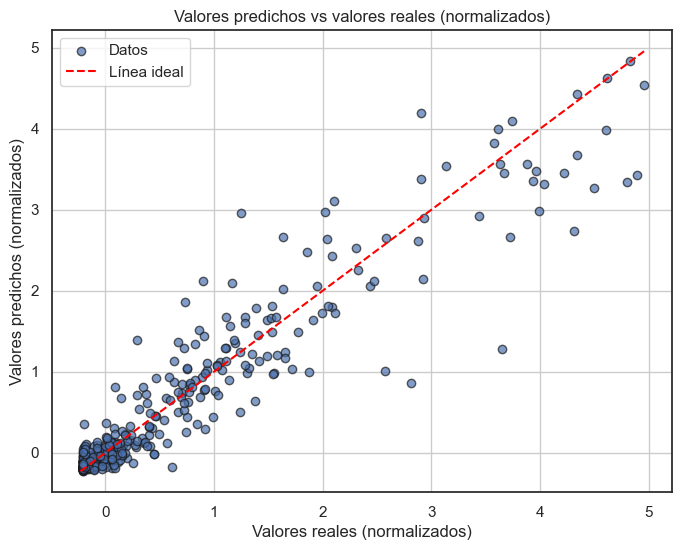

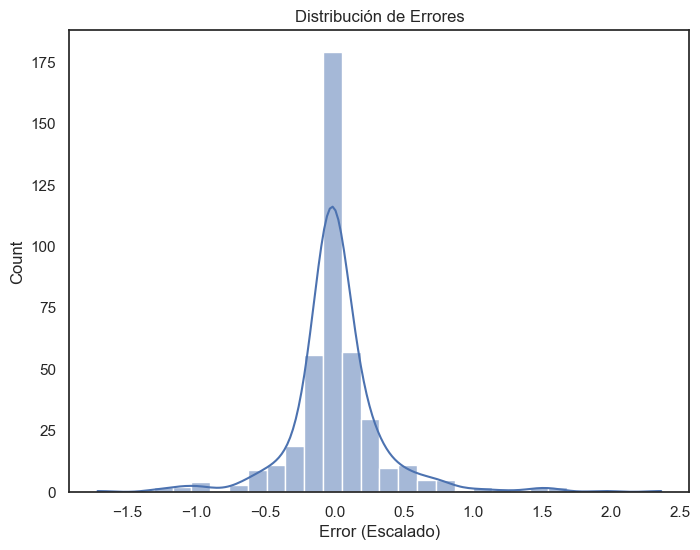

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Valores reales y predichos en el conjunto de prueba (normalizados)
y_test_pred = random_search.best_estimator_.predict(X_test)

# Gráfica de valores predichos vs valores reales 
plt.figure(figsize=(8, 6))
plt.scatter(y_test_scaled, y_test_pred, alpha=0.7, edgecolor='k', label='Datos')
min_val = min(min(y_test_scaled), min(y_test_pred))
max_val = max(max(y_test_scaled), max(y_test_pred))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Línea ideal')  # Línea extendida
plt.xlabel('Valores reales (normalizados)')
plt.ylabel('Valores predichos (normalizados)')
plt.title('Valores predichos vs valores reales (normalizados)')
plt.legend()
plt.grid(True)
plt.show()

# Cálculo de los errores
errores = y_test_scaled - y_test_pred

# Histograma de los errores
errores = y_test_scaled - y_pred_test_scaled
plt.figure(figsize=(8,6))
sns.histplot(errores, bins=30, kde=True)
plt.xlabel('Error (Escalado)')
plt.title('Distribución de Errores')
plt.show()


1. La gráfica presentada muestra una comparación entre los valores reales y los valores predichos por el modelo Gradient Boosting Regressor, ambos en una escala normalizada. Los puntos azules representan esta relación, mientras que la línea roja indica la línea ideal, donde los valores reales y predichos coinciden.

    En términos generales, los puntos se distribuyen de manera cercana a la línea roja, lo que evidencia una relación consistente entre los valores reales y predichos. Esto sugiere que el modelo logra reflejar adecuadamente la tendencia general de los datos. La alineación de los puntos en torno a esta línea indica que las predicciones del modelo están en sintonía con los valores observados.

    Además, se observa que los valores normalizados están comprendidos en un rango entre 0 y aproximadamente 5, lo que asegura que tanto las predicciones como los valores reales mantienen una escala uniforme y comparable. Esto también destaca el uso adecuado de técnicas de preprocesamiento que han permitido trabajar con datos en un rango bien definido.
   
2. Esta gráfica muestra la distribución de los errores del modelo Gradient Boosting Regressor en una escala normalizada. En el eje horizontal se representan los valores del error (diferencia entre los valores reales y predichos), mientras que el eje vertical indica la frecuencia de cada valor de error.

    La distribución presenta un patrón centrado alrededor de 0, lo cual es indicativo de que el modelo no tiende a sobreestimar ni subestimar de forma sistemática las predicciones. Este comportamiento simétrico en torno al valor cero refleja un buen balance en los errores y sugiere que el modelo realiza predicciones consistentes a lo largo del conjunto de datos.

    La forma de campana observada en la curva superpuesta indica que los errores se distribuyen de manera aproximadamente normal. La mayoría de los errores se encuentran concentrados cerca de cero, y su frecuencia disminuye gradualmente al alejarse de este punto, lo que confirma que los errores grandes son poco frecuentes.

### 1. Importancia de las Carcateristicas - Permutacion

#### Permutation Importance Plot

Análisis de Importancia de Características

En esta sección, se evalúa la contribución de cada característica al desempeño del modelo mediante la técnica de **Permutation Importance**. Este enfoque mide cómo la permutación aleatoria de los valores de una característica afecta las predicciones del modelo, proporcionando una visión cuantitativa de su relevancia.

 Pasos realizados:
1. Cálculo de Importancia:
   - Se utilizó el método `permutation_importance` en el conjunto de entrenamiento para medir la sensibilidad del modelo ante cambios en cada característica.
   - Se realizaron 10 permutaciones por característica, evaluando el impacto promedio en las métricas del modelo.

2. Visualización:
   - Las importancias se visualizaron mediante un gráfico de caja (boxplot), mostrando la distribución de las importancias para cada característica.
   - Las características se ordenaron según su importancia media, permitiendo identificar cuáles tienen mayor impacto en las predicciones del modelo.

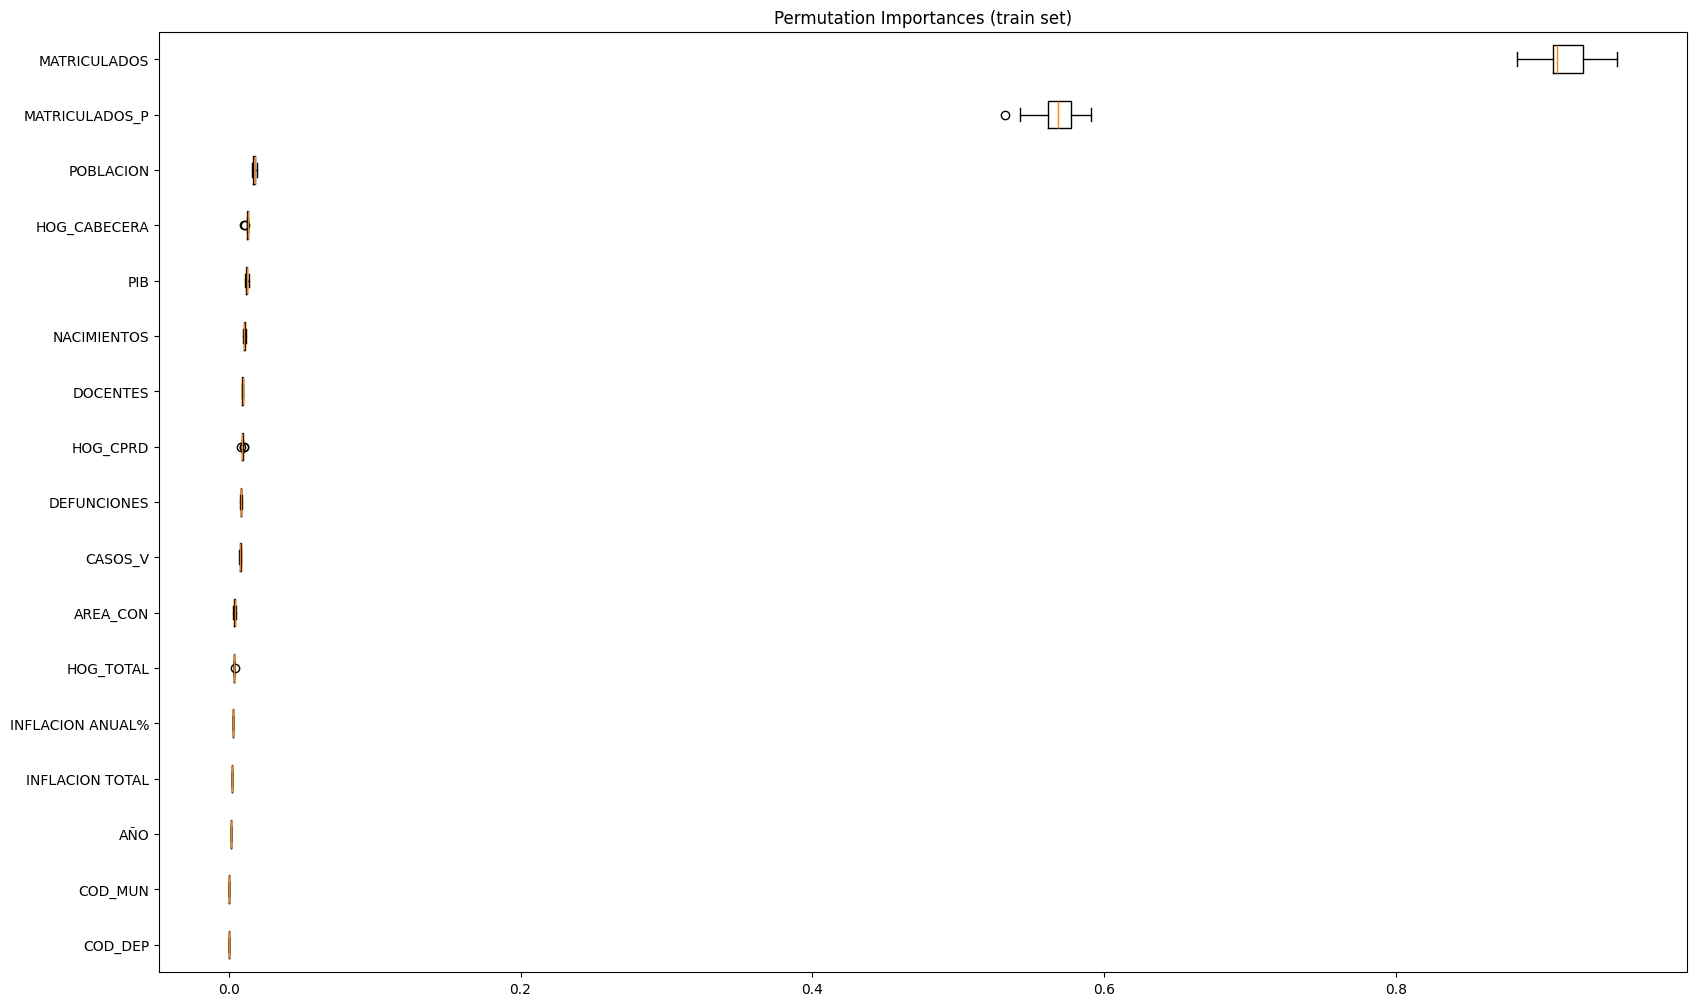

In [64]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Función para visualizar la importancia de características
def visualize_feature_importance(importance_array, column_names):
    # Ordenamos el array según la media de las importancias
    sorted_idx = importance_array.importances_mean.argsort()
    # Visualizamos las importancias de características usando un boxplot
    fig, ax = plt.subplots()
    fig.set_figwidth(16)
    fig.set_figheight(10)
    fig.tight_layout()
    ax.boxplot(importance_array.importances[sorted_idx].T,
               vert=False, labels=[column_names[i] for i in sorted_idx])
    ax.set_title("Permutation Importances (train set)")
    plt.show()

# Calculamos las importancias de características usando permutation_importance
best_model = random_search.best_estimator_

# Aplicamos permutation_importance en el conjunto de entrenamiento
perm_importance = permutation_importance(
    best_model, X_train, y_train_scaled, n_repeats=10, random_state=42, n_jobs=-1
)

# Visualizamos las importancias de características
visualize_feature_importance(perm_importance, X_train.columns)


1. **Impacto en el rendimiento del modelo**: 
   - Basándonos en la prominencia de las variables **MATRICULADOS_P** y **MATRICULADOS**, si estas fueran perturbadas, se esperaría que el rendimiento del modelo (medido en métricas como R²) se redujera significativamente, posiblemente en un rango superior al **30%-40%**, dado que ambas variables dominan la importancia global.
   - Las variables de menor importancia, como **DOCENTES** o **DEFUNCIONES**, probablemente reduzcan el rendimiento del modelo en menos del **5%** al ser perturbadas, lo que indica su baja contribución predictiva.

2. **Comparación relativa entre variables**:
   - **MATRICULADOS_P** tiene una importancia aproximadamente **1.2-1.5 veces mayor** que **MATRICULADOS**. Esto refuerza su rol dominante en la predicción del modelo.
   - Comparando las variables más influyentes con aquellas de baja relevancia, **MATRICULADOS_P** es más de **10-15 veces más importante** que variables como **HOG_TOTAL** o **AREA_CON**, lo que refleja una alta disparidad en cómo el modelo prioriza los datos.

3. **Tendencias observadas**:
   - La gráfica muestra que el modelo se basa principalmente en variables relacionadas directamente con el número de estudiantes matriculados, lo que sugiere una fuerte correlación positiva entre la cantidad de matriculados y la cantidad de graduados.
   - Otras variables como **POBLACION** y **HOG_CABECERA** parecen influir de manera secundaria, lo que podría reflejar un contexto demográfico y social relevante, pero no determinante.
   - Variables como **DOCENTES** y **DEFUNCIONES** tienen un impacto despreciable, lo que podría significar que no son indicadores directos del resultado de graduados.

4. **Implicaciones y uso práctico**:
   - Las dos variables principales (**MATRICULADOS_P** y **MATRICULADOS**) deben recibir mayor atención en el análisis de políticas educativas, ya que su impacto es crucial para predecir graduados.
   - Se podría realizar un análisis más detallado sobre variables demográficas secundarias (**POBLACION**, **HOG_CABECERA**) para comprender mejor su influencia y decidir si su inclusión aporta valor adicional al modelo.


**Coorelacion**

En este bloque de código se realiza una visualización de la matriz de correlación de las variables numéricas del dataset. La matriz de correlación permite identificar la relación lineal entre las variables, proporcionando una visión cuantitativa de cómo interactúan entre sí.

Pasos realizados:

1. Selección de variables  
Se seleccionaron las columnas numéricas del dataset, incluyendo la variable objetivo GRADUADOS.

2. Cálculo de la matriz de correlación  
Se utilizó el método .corr() para calcular los coeficientes de correlación entre todas las variables numéricas, con valores entre -1 y 1.

3. Máscara para ocultar la mitad superior  
Se creó una máscara para mostrar únicamente la mitad inferior de la matriz, ya que la correlación es simétrica y esto facilita la interpretación visual.

4. Creación del Heatmap  
Se utilizó sns.heatmap de Seaborn para generar un mapa de calor que visualiza la matriz de correlación. Los colores indican la intensidad y dirección de la correlación.  
Colores más cercanos al rojo indican correlaciones negativas.  
Colores más cercanos al azul indican correlaciones positivas.  
Colores neutros indican ausencia de correlación.

5. Configuración adicional  
Se añadió anotación de los valores numéricos en cada celda, se definió una paleta de colores divergente y se ajustó el diseño con un título y un tamaño adecuado.

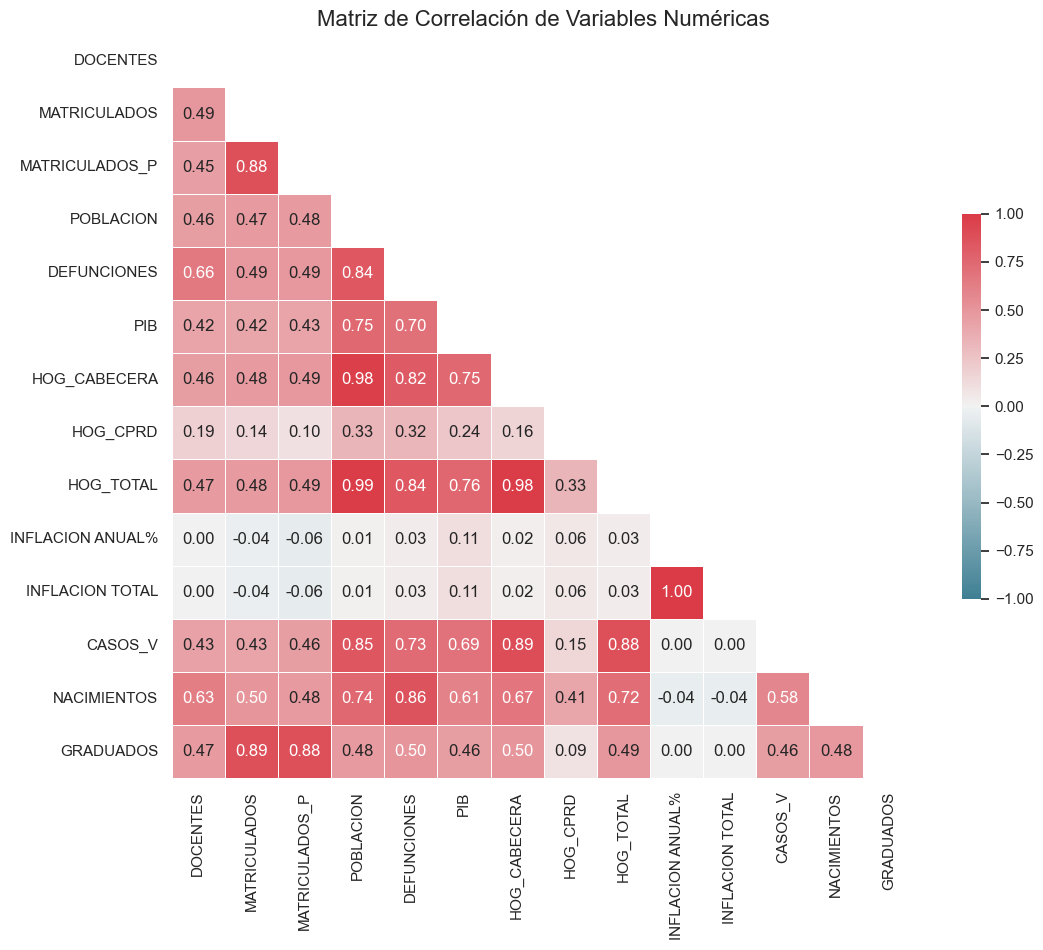

In [65]:
# Gráfica de Correlación

import seaborn as sns

# Seleccionamos las variables numéricas del conjunto de datos original
datos_numericos = Graduados_total[columnas_numericas + [target]]

# Calcular la matriz de correlación
matriz_correlacion = datos_numericos.corr()

# Configurar el estilo de los gráficos
sns.set(style='white')

# Crear una máscara para ocultar la mitad superior de la matriz
mask = np.triu(np.ones_like(matriz_correlacion, dtype=bool))

# Definir la paleta de colores
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Configurar el tamaño de la figura
plt.figure(figsize=(12, 10))

# Crear la Heatmap
sns.heatmap(
    matriz_correlacion,
    mask=mask,
    cmap=cmap,
    vmax=1.0,
    vmin=-1.0,
    center=0,
    annot=True,
    fmt=".2f",
    linewidths=.5,
    cbar_kws={"shrink": .5},
    square=True
)

# Título del gráfico
plt.title('Matriz de Correlación de Variables Numéricas', fontsize=16)

# Mostrar el gráfico
plt.show()

Interpretación de la Matriz de Correlación y Relación con la Importancia de las Variables:

La matriz de correlación presentada ilustra la relación lineal entre las variables numéricas del dataset. Los valores de correlación oscilan entre -1 y 1, donde valores cercanos a 1 indican una correlación positiva fuerte, valores cercanos a -1 indican una correlación negativa fuerte y valores cercanos a 0 indican una relación débil o inexistente.

1. Alta correlación con GRADUADOS  
   - Las variables MATRICULADOS_P (0.88) y MATRICULADOS (0.89) tienen una correlación positiva fuerte con la variable objetivo GRADUADOS. Esto refuerza los resultados de la gráfica de Permutation Importance, donde estas variables se destacaron como las más influyentes en el modelo.  
   - Variables como DEFUNCIONES (0.50), POBLACION (0.48) y NACIMIENTOS (0.58) también muestran correlaciones moderadas con GRADUADOS, indicando que aportan información relevante para las predicciones.  

2. Correlaciones fuertes entre variables predictoras  
   - Existe una fuerte correlación entre HOG_TOTAL y HOG_CABECERA (0.99), lo que sugiere redundancia en la información que aportan estas variables. Aunque ambas pueden influir en el modelo, es posible que el impacto directo de una esté mediado por la otra.  
   - MATRICULADOS y MATRICULADOS_P presentan una correlación alta (0.88), lo cual indica que son indicadores complementarios de una misma tendencia.  

3. Variables con baja correlación  
   - Variables como INFLACION ANUAL% y INFLACION TOTAL muestran correlaciones débiles o nulas con GRADUADOS y otras variables. Esto sugiere que podrían tener una menor contribución directa al modelo, aunque no necesariamente son irrelevantes, ya que el modelo puede captar relaciones no lineales.  

Relación con la Gráfica de Importancia de Variables:

1. Las variables con alta correlación con GRADUADOS, como MATRICULADOS_P y MATRICULADOS, también son las más importantes en el modelo según el análisis de Permutation Importance. Esto respalda su relevancia tanto desde una perspectiva estadística como desde la perspectiva del modelo predictivo.  
2. La baja correlación de variables como INFLACION ANUAL% con GRADUADOS coincide con su menor importancia en el modelo.  
3. Las variables altamente correlacionadas entre sí, como HOG_TOTAL y HOG_CABECERA, pueden ser interpretadas como aportando información redundante. Sin embargo, el modelo maneja estas relaciones para maximizar su capacidad predictiva.  

Conclusión: 

La matriz de correlación valida y complementa el análisis de importancia de características realizado anteriormente. Las variables clave para las predicciones del modelo son las que también muestran correlaciones más fuertes con la variable objetivo, lo que refuerza la confianza en la capacidad del modelo para identificar los factores más relevantes en el dataset.  

### 2. Partial Dependence Plot (PDP)

En este código se genera un conjunto de gráficas llamadas Partial Dependence Plots (PDP) para analizar la relación entre cada característica y la variable objetivo predicha por el modelo. Estas gráficas permiten interpretar cómo cambia la predicción del modelo al modificar una característica específica, manteniendo las demás constantes.

Pasos realizados:

1. Definición de la función `plot_partial_dependence_all_features`  
   Esta función crea múltiples Partial Dependence Plots para todas las características especificadas.  
   Recibe como parámetros el modelo entrenado (`estimator`), los datos de entrada (`X`), los nombres de las características transformadas (`feature_names`), y el número de columnas para organizar las gráficas (`n_cols`).  

2. Cálculo y visualización de las gráficas PDP  
   Para cada característica en la lista `feature_names`, se genera una gráfica utilizando `PartialDependenceDisplay.from_estimator`.  
   La gráfica muestra cómo varía la predicción promedio del modelo cuando se cambia el valor de la característica en cuestión.  
   Las gráficas son generadas sobre una cuadrícula de valores (`grid_resolution=20`) que representa posibles valores de la característica.  
   Si hay características para las que el modelo no puede generar un PDP (por ejemplo, si una característica no es relevante), se captura el error y se omite la gráfica correspondiente.

3. Organización de los subplots  
   Los gráficos son organizados en filas y columnas según el número total de características (`n_features`) y el número de columnas deseado (`n_cols`).  
   Se eliminan los subplots vacíos si el número de características no coincide con el número total de subplots creados.

4. Ajuste de diseño y visualización  
   Se utiliza `plt.tight_layout()` para ajustar los espacios entre las gráficas.  
   Finalmente, las gráficas son mostradas con `plt.show()`.


Error al generar PDP para la característica 'AREA_CON_Artes': Feature 'AREA_CON_Artes' not in feature_names
Error al generar PDP para la característica 'AREA_CON_Ciencias Exactas y Naturales': Feature 'AREA_CON_Ciencias Exactas y Naturales' not in feature_names
Error al generar PDP para la característica 'AREA_CON_Ciencias Sociales y Humanas': Feature 'AREA_CON_Ciencias Sociales y Humanas' not in feature_names
Error al generar PDP para la característica 'AÑO_2018': Feature 'AÑO_2018' not in feature_names
Error al generar PDP para la característica 'AÑO_2019': Feature 'AÑO_2019' not in feature_names
Error al generar PDP para la característica 'AÑO_2020': Feature 'AÑO_2020' not in feature_names
Error al generar PDP para la característica 'AÑO_2021': Feature 'AÑO_2021' not in feature_names
Error al generar PDP para la característica 'AÑO_2022': Feature 'AÑO_2022' not in feature_names
Error al generar PDP para la característica 'AÑO_2023': Feature 'AÑO_2023' not in feature_names


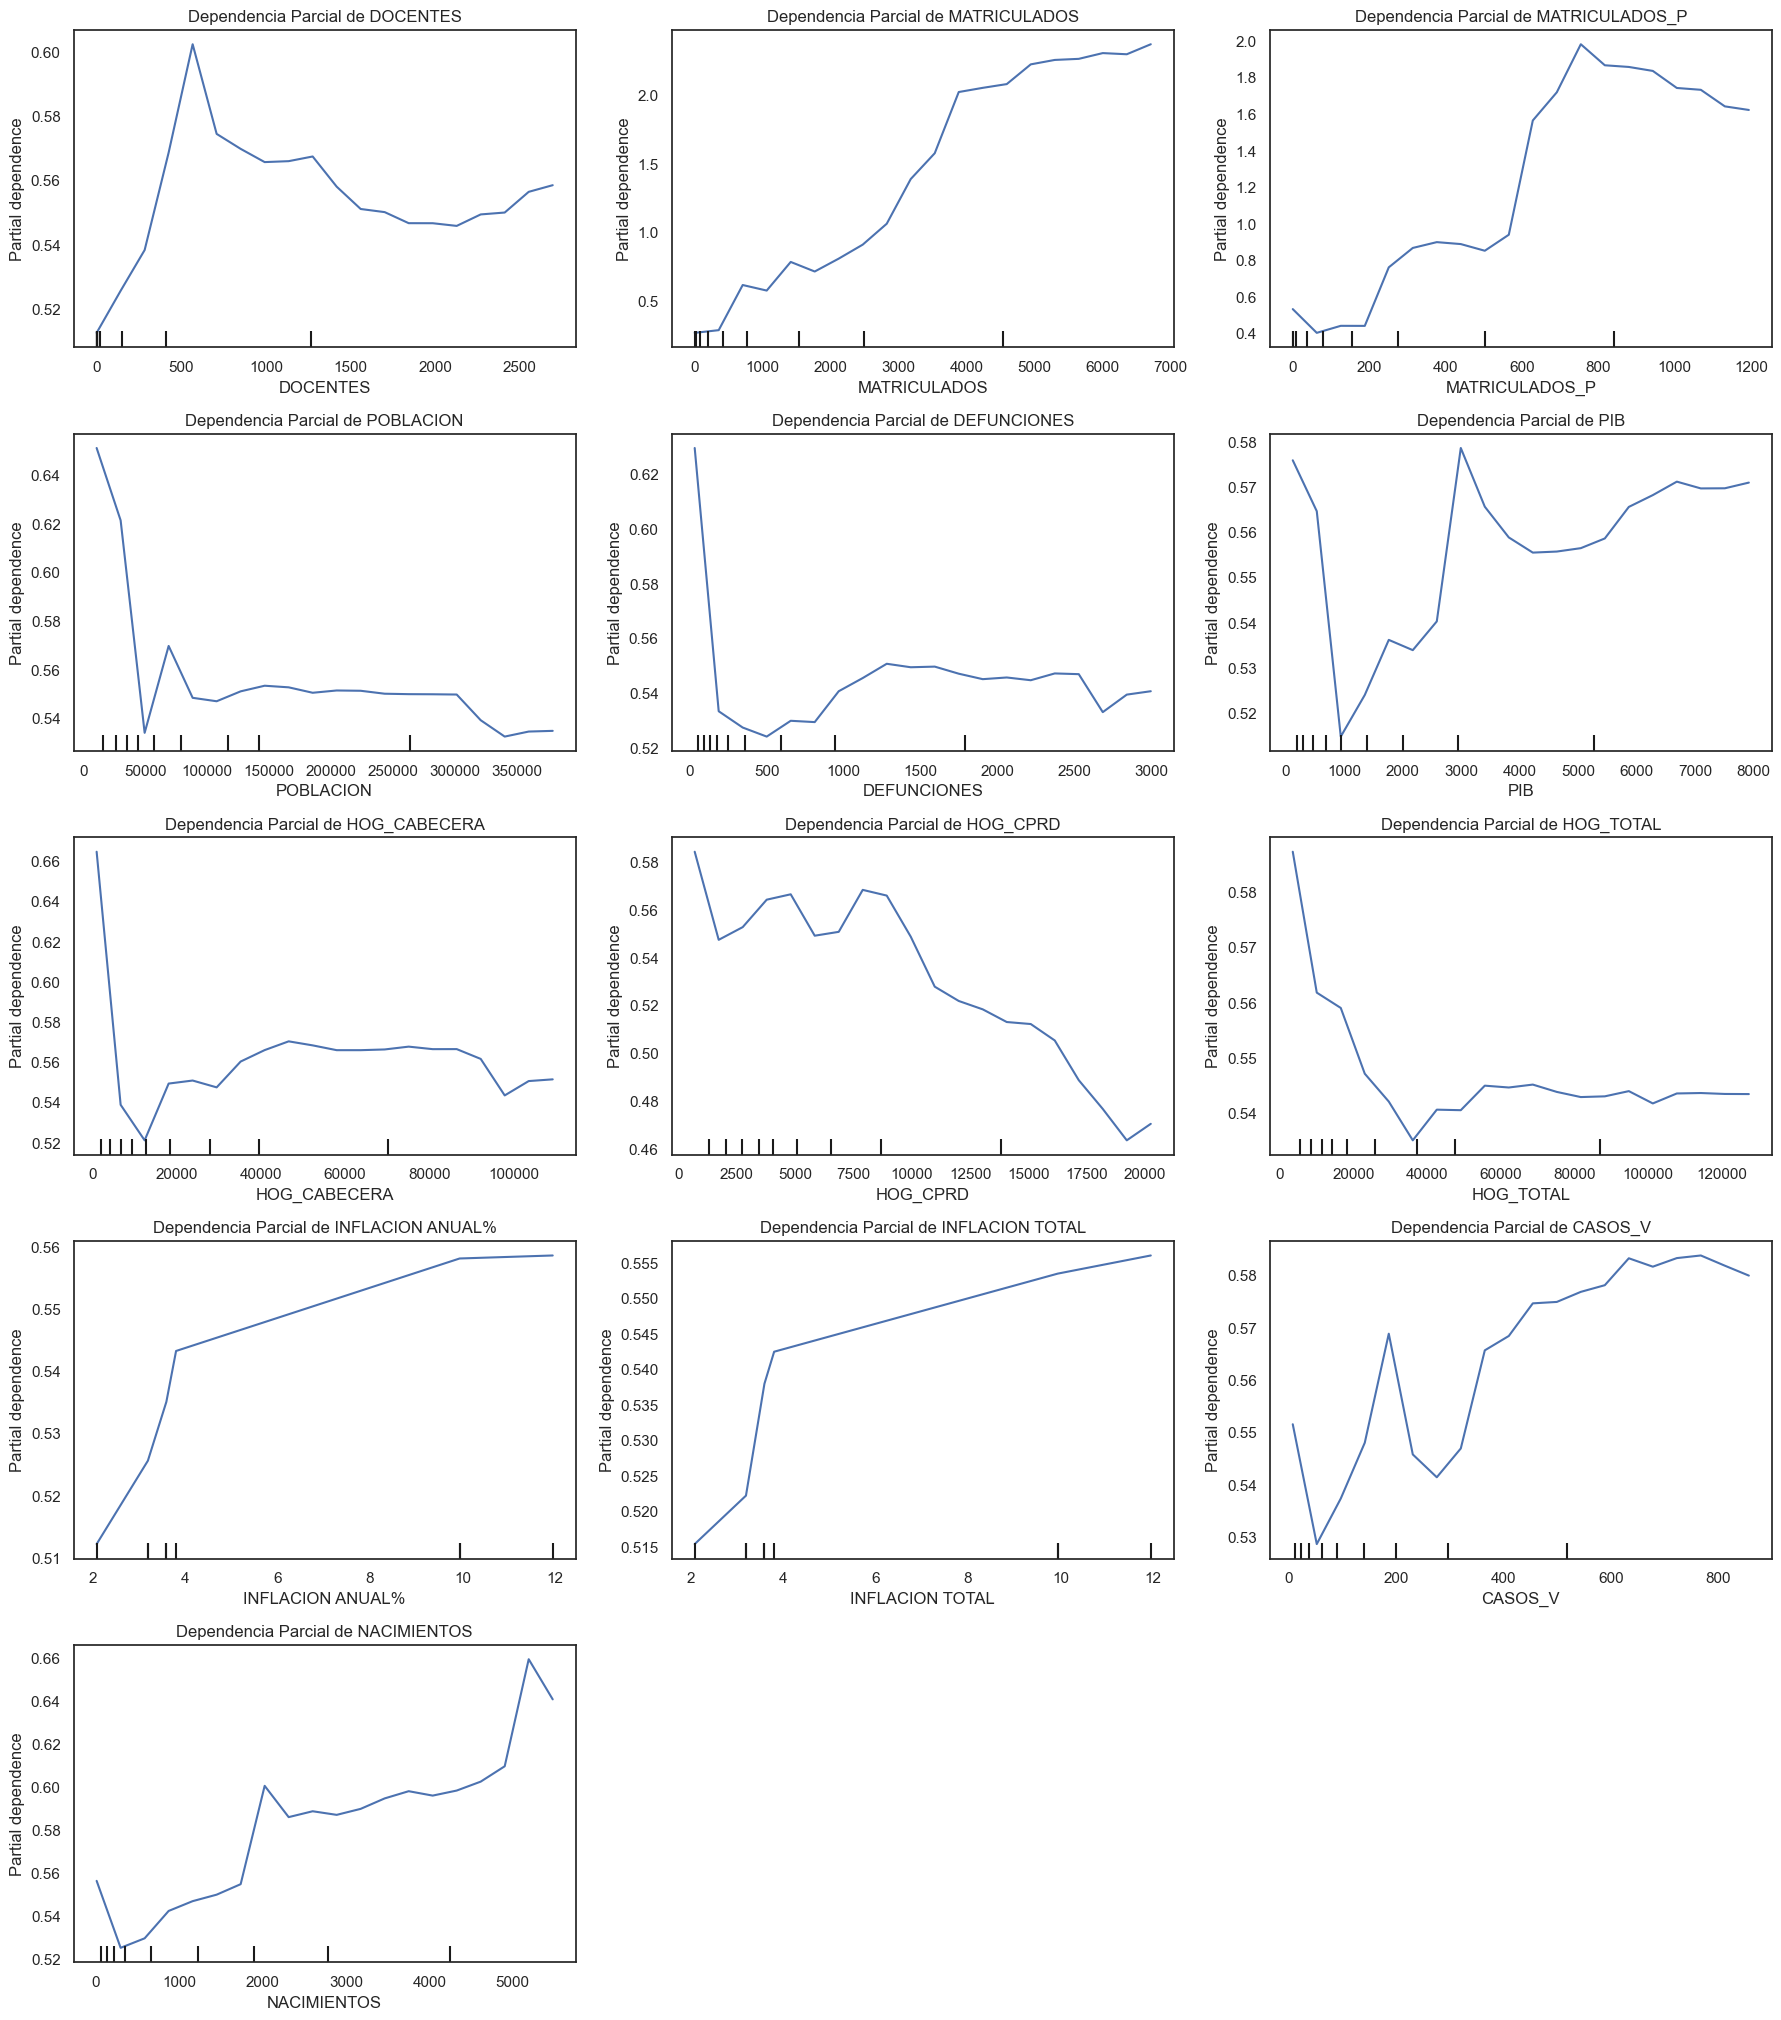

In [43]:
# Partial Dependence Plots (PDP) para Todas las Características Transformadas
from math import ceil

def plot_partial_dependence_all_features(estimator, X, feature_names, n_cols=3):
    """
    Genera Partial Dependence Plots para todas las características especificadas.

    Parámetros:
    - estimator: El modelo entrenado (pipeline completo).
    - X: Datos de entrada (originales, antes del preprocesamiento).
    - feature_names: Lista completa de nombres de las características transformadas.
    - n_cols: Número de columnas en la figura de subplots.
    """
    # Determinar la cantidad de subplots necesarios
    n_features = len(feature_names)
    n_rows = ceil(n_features / n_cols)
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
    axs = axs.flatten()
    
    for i, feature in enumerate(feature_names):
        try:
            PartialDependenceDisplay.from_estimator(
                estimator,
                X,
                [feature],
                ax=axs[i],
                kind='average',  # Puedes cambiar a 'both' para incluir también las líneas de tendencia
                grid_resolution=20,
                random_state=123
            )
            axs[i].set_title(f'Dependencia Parcial de {feature}')
        except ValueError as e:
            print(f"Error al generar PDP para la característica '{feature}': {e}")
            fig.delaxes(axs[i])
    
    # Eliminar subplots vacíos si los hay
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])
    
    plt.tight_layout()
    plt.show()

# Generar las gráficas de Dependencia Parcial para todas las características transformadas
plot_partial_dependence_all_features(
    estimator=random_search.best_estimator_,
    X=X_train,
    feature_names=all_feature_names,  # Pasamos los nombres transformados de las características
    n_cols=3  # Puedes ajustar este valor según prefieras
)

 Análisis individual de las gráficas de Dependencia Parcial (Partial Dependence Plots)

1. **DOCENTES**  
   La predicción aumenta significativamente al inicio con un bajo número de docentes, alcanzando un pico y luego disminuye gradualmente a medida que el número de docentes crece. Esto indica que, aunque un incremento inicial en docentes es beneficioso, eventualmente su impacto se estabiliza o incluso disminuye.

2. **MATRICULADOS**  
   Existe una relación positiva continua. A medida que aumenta el número de matriculados, las predicciones del modelo también aumentan, lo que sugiere que esta variable tiene un efecto constante y positivo en el resultado.

3. **MATRICULADOS_P**  
   El comportamiento es similar al de la variable anterior, pero con variaciones más pronunciadas. El efecto positivo se incrementa hasta cierto punto antes de estabilizarse o disminuir ligeramente en niveles muy altos.

4. **POBLACION**  
   Se observa un impacto inicial positivo en la predicción, pero rápidamente se estabiliza y presenta fluctuaciones menores en niveles altos de población, indicando que esta variable podría no ser tan significativa más allá de cierto umbral.

5. **DEFUNCIONES**  
   El efecto inicial es negativo, pero luego se estabiliza con ligeros aumentos en niveles medios. Esto sugiere que un aumento en el número de defunciones puede tener un impacto negativo en las predicciones del modelo.

6. **PIB**  
   Existe una relación compleja. A niveles bajos, el PIB tiene un efecto positivo moderado, pero muestra fluctuaciones en niveles medios y altos, sugiriendo interacciones más complejas o dependencias con otras variables.

7. **HOG_CABECERA**  
   La predicción disminuye rápidamente con valores iniciales altos de esta variable, luego se estabiliza y comienza a mostrar pequeñas oscilaciones. Esto podría indicar una influencia inicial negativa significativa.

8. **HOG_CPRD**  
   La relación es principalmente negativa, con una tendencia descendente a medida que aumenta el número de hogares en esta categoría. Esto indica que esta variable podría estar correlacionada negativamente con el objetivo.

9. **HOG_TOTAL**  
   Existe una fuerte caída inicial en la predicción con valores bajos, pero se estabiliza con un ligero incremento en niveles altos, lo que podría sugerir una relación no lineal.

10. **INFLACION ANUAL%**  
   Muestra una relación positiva constante. A medida que aumenta la inflación anual, las predicciones también crecen de forma lineal, lo que sugiere que esta variable tiene un impacto directo y positivo en el modelo.

11. **INFLACION TOTAL**  
   Similar a la variable anterior, aunque el efecto parece ser ligeramente menos pronunciado. Esto indica que la inflación total podría tener una relación positiva, pero menos fuerte que la inflación anual.

12. **CASOS_V**  
   Existe una relación fluctuante. En niveles bajos y medios, la predicción aumenta y disminuye, sugiriendo una interacción compleja o dependencias con otras variables.

13. **NACIMIENTOS**  
   La relación es positiva, especialmente a niveles bajos y medios. A medida que el número de nacimientos aumenta, también lo hacen las predicciones, lo que sugiere un impacto positivo consistente.

Cada gráfico muestra cómo el modelo responde a los cambios en cada característica, reflejando la importancia relativa y la naturaleza de la relación. Algunas variables, como MATRÍCULA y NACIMIENTOS, tienen un impacto positivo claro, mientras que otras, como HOG_CPRD o HOG_TOTAL, muestran efectos más complejos o negativos. Estas relaciones permiten entender cómo el modelo utiliza cada característica para realizar sus predicciones.

### 3. Local Interpretable Model - agnostic Explanations (LIME)

En este análisis se utilizó LIME (Local Interpretable Model-agnostic Explanations) para interpretar las predicciones del modelo Gradient Boosting en un caso específico. A continuación se describen los pasos realizados:

1. **Recuperación del preprocesador y modelo entrenado**  
   Se separaron las etapas del pipeline entrenado, específicamente el preprocesador de datos (`columntransformer`) y el modelo de predicción (`gradientboostingregressor`), para utilizarlos en la explicación de LIME.

2. **Transformación de los datos de prueba**  
   Se transformaron las características del conjunto de prueba utilizando el preprocesador entrenado, ya que LIME necesita los datos en el formato procesado para generar explicaciones consistentes con las entradas del modelo.

3. **Configuración de LIME**  
   Se creó un objeto `LimeTabularExplainer` configurado para realizar explicaciones en el modo de regresión. Se le proporcionaron los datos transformados de entrenamiento, los nombres de las características transformadas y el nombre de la variable objetivo.

4. **Selección de una muestra específica**  
   Se seleccionó un caso particular del conjunto de prueba, identificado por su índice, para generar una explicación local de cómo el modelo realiza la predicción para ese caso.

5. **Explicación de la predicción de la muestra**  
   Se generó una explicación utilizando LIME, mostrando cómo cada característica contribuyó positiva o negativamente a la predicción del modelo para la muestra seleccionada.

6. **Visualización de la explicación**  
   Se presentó la explicación de LIME en formato interactivo utilizando `exp.show_in_notebook`, lo que permite explorar los detalles directamente.

7. **Extracción de las contribuciones de las características**  
   Se obtuvieron las contribuciones individuales de cada característica (valores de impacto) y sus nombres a partir de la explicación generada por LIME.

8. **Visualización gráfica de las contribuciones**  
   Se utilizó un gráfico de barras horizontales para mostrar cómo cada característica influyó en la predicción del modelo.  
   Las barras representan el impacto en la predicción, con colores que reflejan la dirección (positivo o negativo) y la magnitud de la influencia.

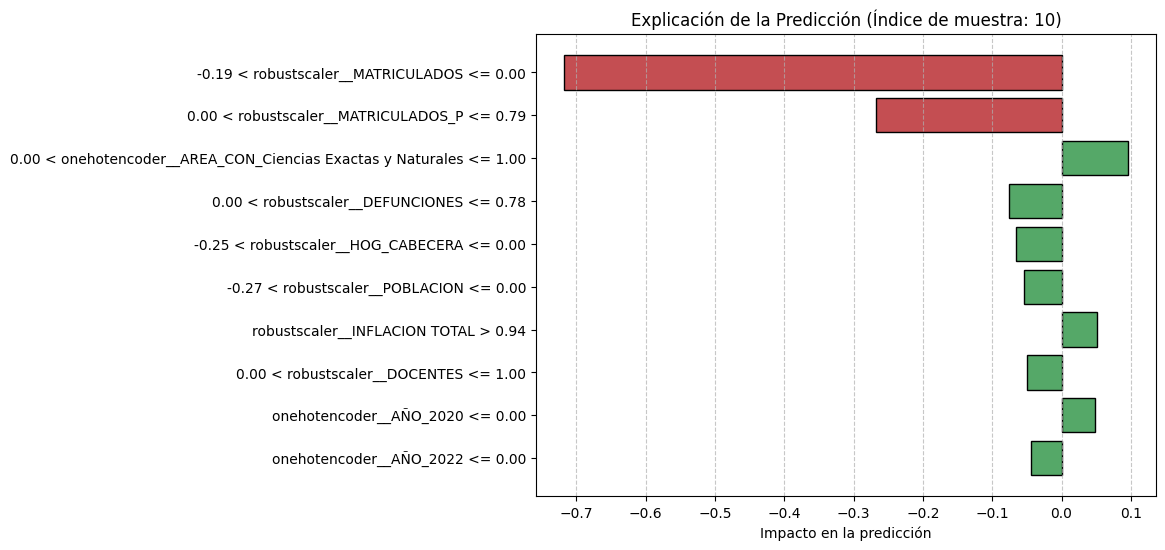

In [63]:
from lime.lime_tabular import LimeTabularExplainer

# Recuperamos el preprocesador y el modelo del pipeline
preprocessor = random_search.best_estimator_.named_steps['columntransformer']
model = random_search.best_estimator_.named_steps['gradientboostingregressor']

# Preprocesamos los datos de prueba para alimentar a LIME
X_test_transformed = preprocessor.transform(X_test)

# Creamos el explainer LIME
explainer = LimeTabularExplainer(
    training_data=preprocessor.transform(X_train),
    feature_names=preprocessor.get_feature_names_out(),
    class_names=["Predicción"],
    mode="regression"
)

# Seleccionamos una muestra del conjunto de prueba para explicar
sample_idx = 10  # Cambia este índice para explorar otras muestras
sample = X_test.iloc[sample_idx]
sample_transformed = X_test_transformed[sample_idx]

# Explicamos la predicción de la muestra seleccionada
exp = explainer.explain_instance(
    data_row=sample_transformed,
    predict_fn=model.predict
)

# Visualizamos la explicación de LIME
exp.show_in_notebook()

# Extraemos los pesos de características explicados por LIME
lime_explanation = exp.as_list()
feature_names, feature_values = zip(*lime_explanation)

# Generamos colores para las barras
bar_colors = get_bar_colors(feature_values)

# Visualizamos las explicaciones usando barras horizontales
plt.figure(figsize=(8, 6))
y_pos = np.arange(len(feature_names))
plt.barh(y_pos, feature_values, color=bar_colors, edgecolor='black')
plt.yticks(y_pos, feature_names)
plt.xlabel('Impacto en la predicción')
plt.title(f'Explicación de la Predicción (Índice de muestra: {sample_idx})')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


La gráfica presentada muestra una explicación local de la predicción generada por el modelo para un caso específico, utilizando LIME para identificar cómo cada característica contribuyó positiva o negativamente al resultado. A continuación, se detalla la interpretación:

1. **MATRICULADOS**  
   - Tiene el impacto negativo más fuerte en la predicción, reduciéndola significativamente. Esto indica que, en el caso analizado, el valor específico de esta variable influye en una disminución importante en la predicción del modelo.

2. **MATRICULADOS_P**  
   - También tiene un impacto negativo notable, aunque menor que `MATRICULADOS`. Contribuye a reducir la predicción en menor medida.

3. **AREA_CON_Ciencias Exactas y Naturales**  
   - Tiene un impacto positivo considerable en la predicción. Esto sugiere que el hecho de que esta muestra pertenezca al área de Ciencias Exactas y Naturales aumentó la predicción del modelo.

4. **DEFUNCIONES**  
   - Tiene un impacto positivo leve en la predicción, indicando que los valores asociados a esta variable incrementan moderadamente la predicción.

5. **HOG_CABECERA** y **POBLACION**  
   - Ambas tienen impactos negativos menores en la predicción. Esto indica que los valores de estas variables disminuyen ligeramente la predicción del modelo en este caso.

6. **INFLACION TOTAL**  
   - Presenta un impacto positivo leve en la predicción. Esto sugiere que, en este caso, la inflación total tiene una relación directa con el aumento en la predicción.

7. **DOCENTES**  
   - Tiene un impacto positivo marginal, indicando que los valores de esta característica aumentan ligeramente la predicción.

8. **AÑO_2020** y **AÑO_2022**  
   - Estas variables categóricas, representadas mediante codificación OneHot, tienen un impacto positivo marginal en la predicción. Esto sugiere que el año en que se encuentra el caso analizado influye de manera leve en el aumento de la predicción.

La gráfica permite observar cómo cada característica afecta localmente la predicción del modelo para el caso específico analizado. Los resultados indican que las variables `MATRICULADOS` y `MATRICULADOS_P` tienen las mayores contribuciones negativas, mientras que `AREA_CON_Ciencias Exactas y Naturales` y otras variables relacionadas como `DEFUNCIONES` o `INFLACION TOTAL` presentan contribuciones positivas. Este análisis local ayuda a comprender qué factores tienen más peso en la decisión del modelo en este contexto particular.

# Autor: Juan Esteban Londoño Guatibonza, Universidad Externado de Colombia

# Dirigido por: Daniel Godoy